In [1]:
import numpy as np
import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
import json
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/func_0'

In [3]:
file = os.path.join(directory, 'tsne', '20191224_X_labels.npy')
labels = np.load(file)
#file = os.path.join(directory, 'tsne', '20191224_X.npy')
#X = np.load(file)

In [4]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 139.79 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.15 sec


In [5]:
cap = cv2.VideoCapture('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/imports/fictrac/fictrac-20190218_133014-raw.avi')
i=0
frames = []
ret = True
while ret is True and i<90000:
    i+=1
    if i%1000 == 0:
        print(i)
    # Capture frame-by-frame
    ret, frame = cap.read()
    frames.append(frame)
cap.release()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000


In [6]:
def interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, interp_to):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3
    filter_window = 51
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'all':
        dx = np.asarray(fictrac['dRotLabX'])
        dy = np.asarray(fictrac['dRotLabY'])
        dz = np.asarray(fictrac['dRotLabZ'])
        dx = scipy.signal.savgol_filter(dx,filter_window,3) * sphere_radius * 50 * 100 * 10
        dy = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
        dz = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
        fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    elif behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    else:
        print('invalid behavior')
    
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    
    if interp_to is 'timestamps':
        fictrac_interp = fictrac_interp_temp(timestamps[:,25])
    elif interp_to is 'xnew':
        fictrac_interp = fictrac_interp_temp(xnew)
    else:
        print('Invalid interp_to ({})'.format(interp_to))

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [7]:
resolution = 20 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
xnew = np.arange(0,expt_len,resolution)

fictracs_high_res = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs_high_res[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'xnew')

fictracs = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'timestamps')

In [8]:
np.where(labels==1)[0]

array([  26, 1621, 1674, 2025, 2203, 2436, 2489, 2499, 2711, 2742, 2758,
       2789, 2822, 2826, 2870, 2937, 2950, 2974, 3069, 3188, 3216, 4129,
       4271, 4296, 4311, 4548])

In [10]:
len(np.where(labels==1)[0])

26

In [1]:
max(labels)

NameError: name 'labels' is not defined

In [13]:
for i in range(max(labels)):
    print(len(np.where(labels==i)[0]))

1453
26
13
14
44
19
41
15
22
18
37
33
15
71
19
20
44
18
50
14
161
14
25
23
17
26
33
13
41
46
34
28
21
12
37
21
47
14
17
17
27
39
139
34
61
12
19
26
26
19
43
90
74
217
79
18
19
126
271
195
144
13
139
17


CLUSTER 1
Frame 0 of 40
error
Frame 1 of 40
error
Frame 2 of 40
error
Frame 3 of 40
error
Frame 4 of 40
error
Frame 5 of 40
error
Frame 6 of 40
error
Frame 7 of 40
error
Frame 8 of 40
error
Frame 9 of 40
error
Frame 10 of 40
error
Frame 11 of 40
error
Frame 12 of 40
error
Frame 13 of 40
error
Frame 14 of 40
error
Frame 15 of 40
error
Frame 16 of 40
error
Frame 17 of 40
error
Frame 18 of 40
error
Frame 19 of 40
error
Frame 20 of 40
error
Frame 21 of 40
error
Frame 22 of 40
error
Frame 23 of 40
error
Frame 24 of 40
error
Frame 25 of 40
error
Frame 26 of 40
error
Frame 27 of 40
error
Frame 28 of 40
error
Frame 29 of 40
error
Frame 30 of 40
error
Frame 31 of 40
error
Frame 32 of 40
error
Frame 33 of 40
error
Frame 34 of 40
error
Frame 35 of 40
error
Frame 36 of 40
error
Frame 37 of 40
error
Frame 38 of 40
error
Frame 39 of 40
error


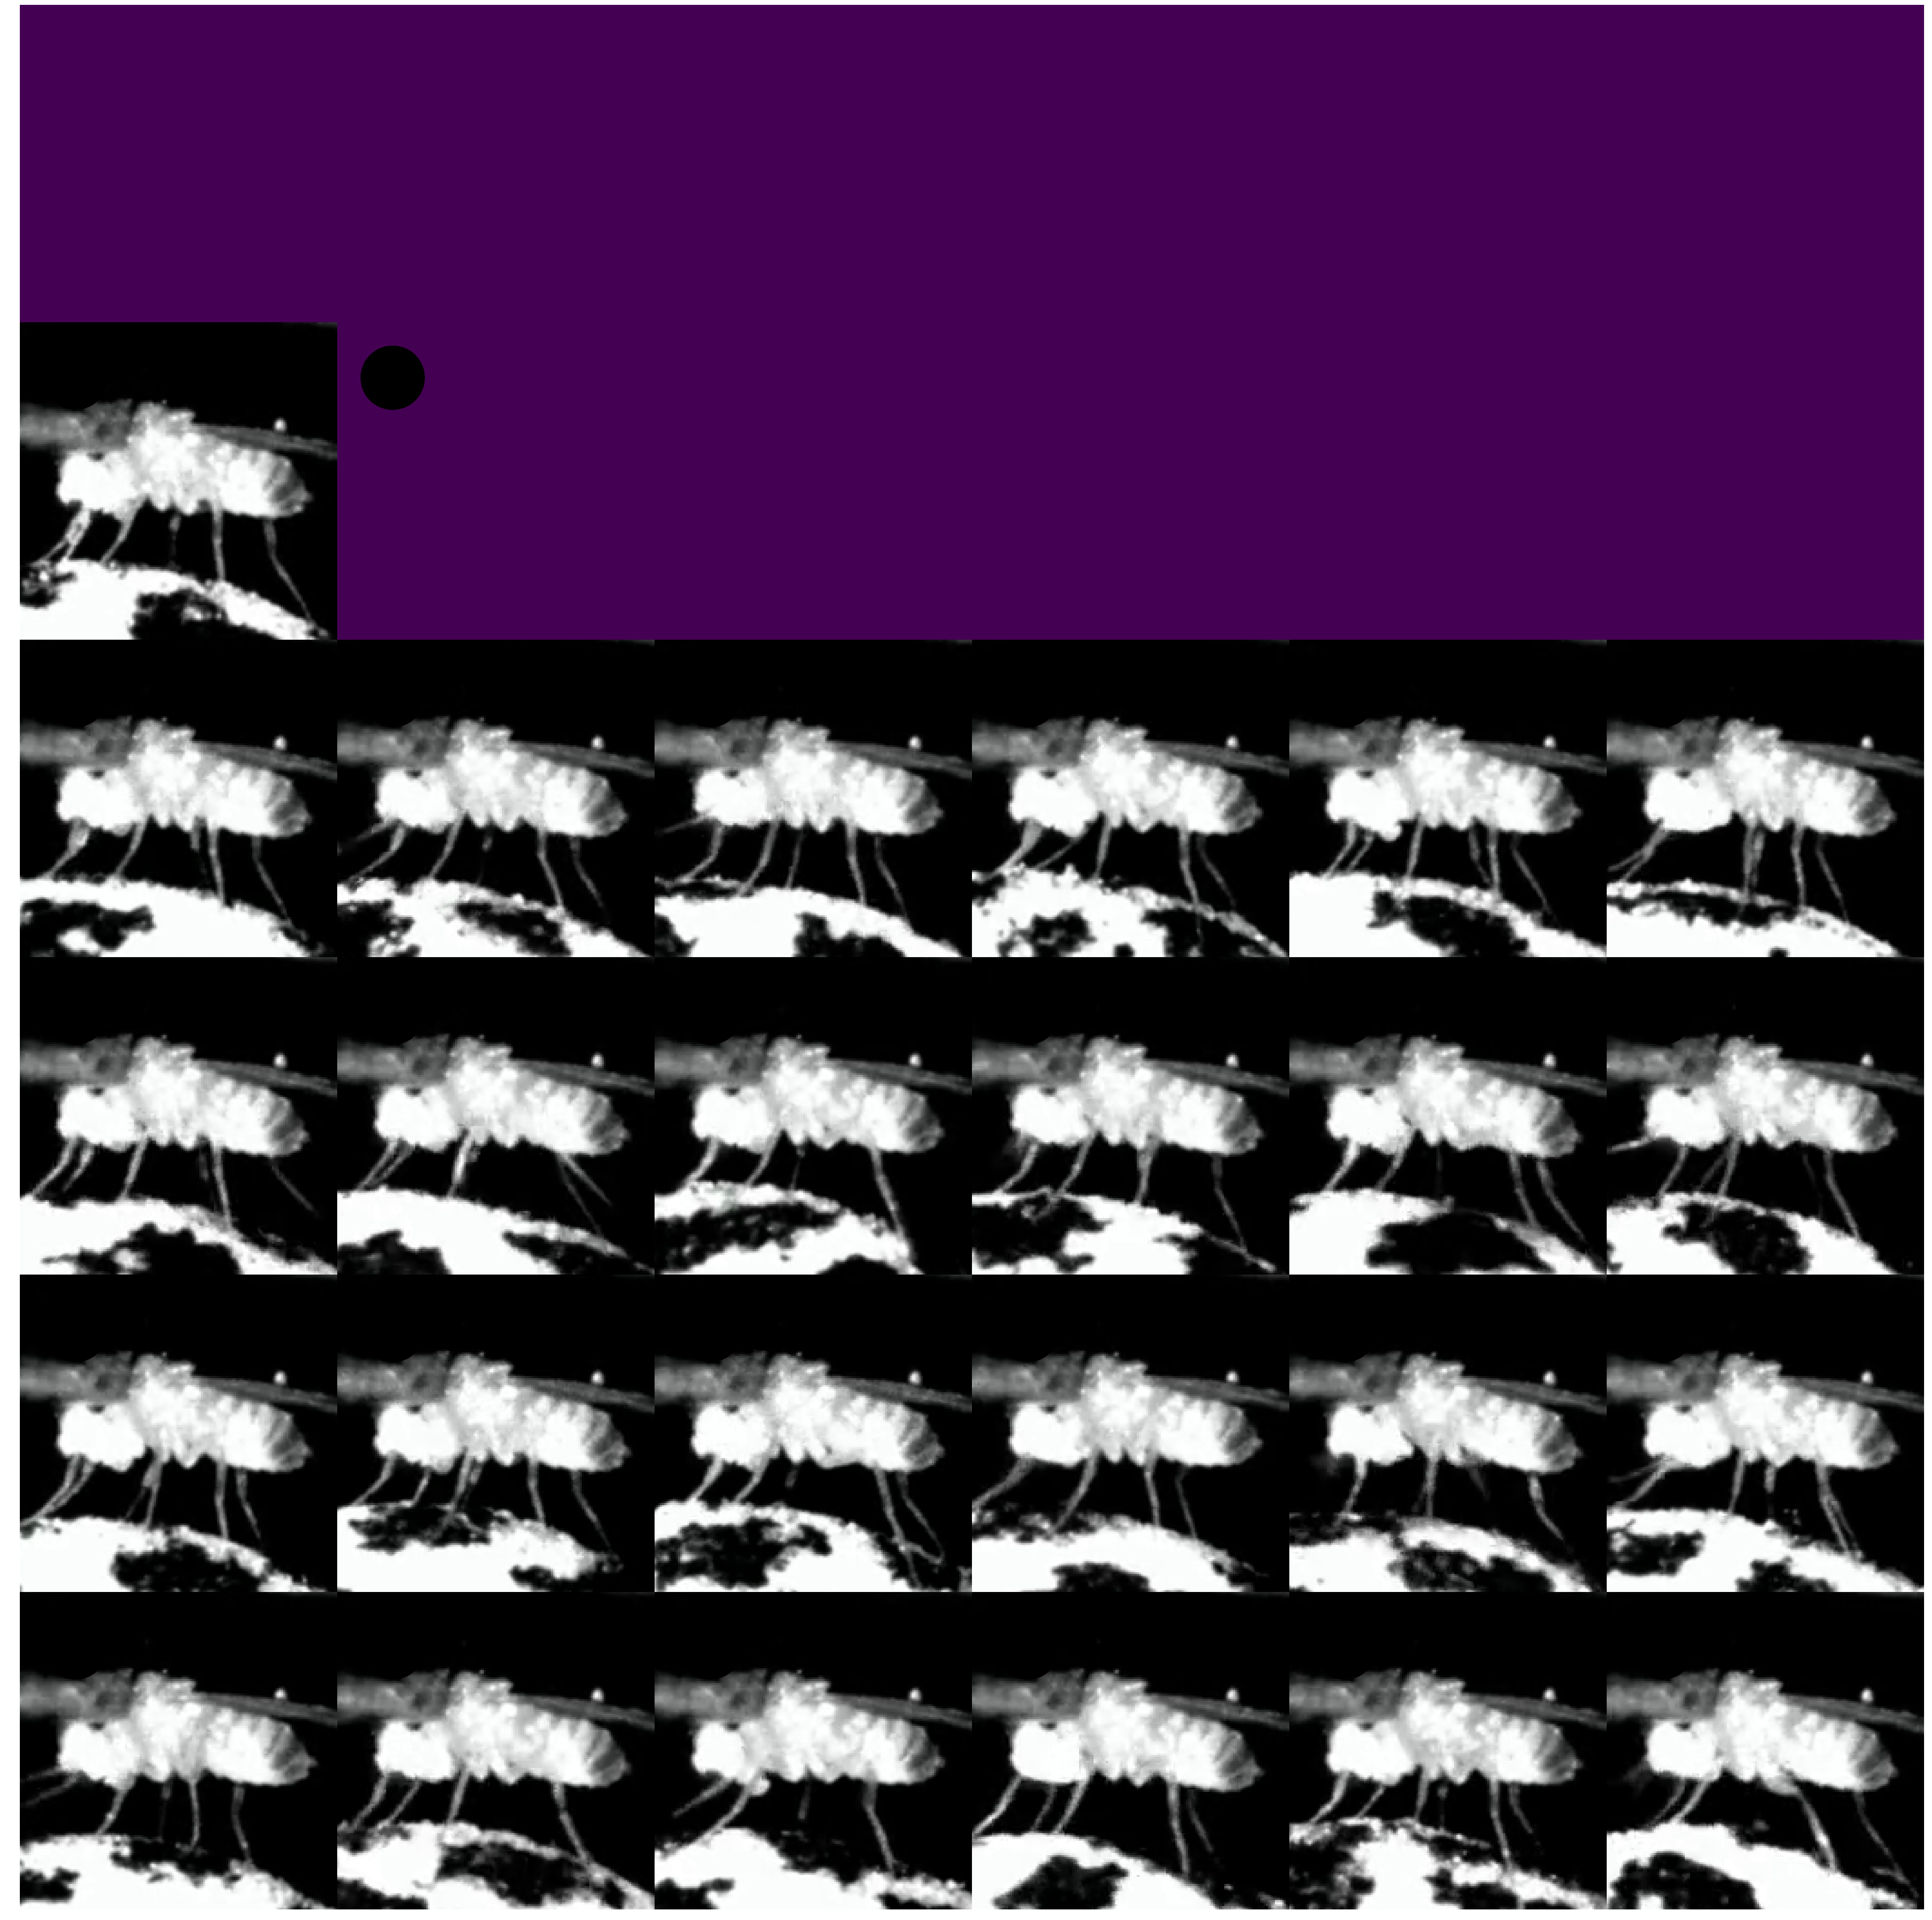

In [11]:
for CLUSTER_NUM in [1]:
    print('CLUSTER {}'.format(CLUSTER_NUM))
    fig = plt.figure(figsize=(10,10))
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20191220_cluster_videos/cluster_{}'.format(CLUSTER_NUM)
    #os.mkdir(save_path)
    NUM_AXES = 26
    #CLUSTER_NUM = 1
    PRE_MS = 1000
    POST_MS = 1000
    STEP_MS = 50
    IMAGING_RATE = 400 # in ms for bruker

    IMAGING_RATE = IMAGING_RATE/2
    num_frames = int((POST_MS+PRE_MS)/STEP_MS)
    width = int(np.ceil(np.sqrt(NUM_AXES)))
    axes = []
    images = []
    for i in range(width**2): # must be 0 index
        x = i%width
        y = int(np.ceil((i+1)/width))
        ax = fig.add_axes([x, y, 1, 1])
        #im = ax.imshow(frames[100][35:210,325:500,:])
        im = ax.imshow([[0,0],[0,0]])
        ax.axis('off')
        images.append(im)
        axes.append(ax)

    for i in range(num_frames):
        print('Frame {} of {}'.format(i, num_frames))
        brain_idx = np.where(labels==CLUSTER_NUM)[0]
        for k,j in enumerate(brain_idx):
            if k< NUM_AXES:
                trigger_time = timestamps[:,20][j]
                time = trigger_time - PRE_MS + STEP_MS*i
                behavior_idx = np.searchsorted(xnew, time)
                try:
                    images[k].set_array(frames[behavior_idx][35:210,325:500,:])
                except: #for catching behavior_idx that are outside of imaging
                    print('error')
                    images[k].set_array([[0,0],[0,0]])
                if trigger_time-IMAGING_RATE < time < trigger_time+IMAGING_RATE:
                    circle = plt.Circle((-0.15, -0.15), .2, color='r')
                else:
                    circle = plt.Circle((-0.15, -0.15), .2, color='k')
                axes[k].add_artist(circle)
        fname = os.path.join(save_path, '{0:05d}.png'.format(i))
        #plt.savefig(fname,dpi=10,bbox_inches='tight')